In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astroquery.simbad import Simbad
import arviz as az

import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *
from astropy import units as u
from astropy import constants as const
import pickle
from utils import *
import warnings
warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox


04_17_25


In [2]:
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib.gridspec import GridSpec
from astropy.time import Time


In [3]:
obj_113 = 7, 9, 11, 16, 18, 19, 21, 23  
obj_112 = 6, 7, 13, 23

In [4]:
p112_ver = {6: 2, 
             7: 1,
             13: 1, #another version exists
             23: 1,
            }

p113_ver = {7: 1,
             9: 1,
             10: 1,
             11: 2, #another version exists
             16: 2, #another version exists
             18: 1,
             19: 1,
             21: 1,
             23: 1,
            }

In [5]:
df_p112 = pd.read_csv('df_p112.csv')
df_p113 = pd.read_csv('df_p113.csv')


In [6]:
def get_stats(binaries, program, ver):
    stat_dict = {}
    for i,RG in enumerate(binaries):
        version = ver[RG]
        print(RG)
        fname = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            trace = pickle.load(handle)
        colnames = ['P','e','K','v0']
        summary = az.summary(trace, colnames)
        rhat = summary['r_hat'].to_list() 
        
        stat_dict[i] = [RG, summary['mean']['P'], summary['sd']['P'], 
                        summary['mean']['e'], summary['sd']['e'], 
                        summary['mean']['K'], summary['sd']['K'],
                        summary['r_hat']['P'], summary['r_hat']['e'],
                        ]
    df = pd.DataFrame(stat_dict)
    df = df.T
    df.columns = ['RG_id','P','err_P','e','err_e','K','err_K','r_hat_P','r_hat_e']
    if '112' in program:
        df1 = df_p112
    elif '113' in program:
        df1 = df_p113
    df = pd.merge(df, df1, on='RG_id')
    if '112' in program:
        df['program'] = [112]*len(df)
    else:
        df['program'] = [113]*len(df)
    return df

stat_dict_112 = get_stats(obj_112, 'p112', p112_ver)
stat_dict_113 = get_stats(obj_113, 'p113', p113_ver)

data0 = pd.concat([stat_dict_112,stat_dict_113]).reset_index()



6
7
13
23
7
9
11
16
18
19
21
23


In [7]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [8]:
merged_113 = pd.read_csv('merged_113.csv')
merged_112 = pd.read_csv('merged_112.csv')

In [9]:
   
with open('obj_dir_p112.pkl', 'rb') as f:
    obj_dir_p112 = pickle.load(f)
    
with open('obj_dir_p113.pkl', 'rb') as f:
    obj_dir_p113 = pickle.load(f)

In [10]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [11]:
data = pd.merge(data0, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep']], left_on='galah_id', right_on='sobject_id')

In [12]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [13]:
for i, row in data.iterrows():
#     if i != 1: continue
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    K = abs(K)
    Msini, success = msini_func(K, P, e, Mstar)
    Msini_jup   = Msini/u.M_jup.to(u.kg)
    Msini_solar = Msini/u.Msun.to(u.kg)

    if success:
        if i != 5: continue
        print(K, P, e, Mstar)
        print(i,'%.2f Mstar \t %.3f Mjup \t %.3f Msun' % (Mstar, Msini_jup, Msini_solar))

0.035 20.694 0.181 0.9565468227493464
5 0.96 Mstar 	 0.452 Mjup 	 0.000 Msun


In [14]:
program = 'p112'
version = 1

p112_d = {6:{'Mjup':None, 'Msol': None}, 7:{'Mjup':None, 'Msol': None},
          13:{'Mjup':None, 'Msol': None}, 23:{'Mjup':None, 'Msol': None}
         }
p113_d = {7:{'Mjup':None, 'Msol': None}, 9:{'Mjup':None, 'Msol': None},
          11:{'Mjup':None, 'Msol': None}, 16:{'Mjup':None, 'Msol': None},
          18:{'Mjup':None, 'Msol': None}, 19:{'Mjup':None, 'Msol': None},
          21:{'Mjup':None, 'Msol': None}, 23:{'Mjup':None, 'Msol': None}
         }

def get_msini(objects, program, version, savedict):
    for RG in objects:
        print(program, RG)
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        colnames = ['P','e','K','v0']

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        Mjup = []
        Msol = []
        
        for i in range(len(Ks)):
            K, P, e = Ks[i], Ps[i], es[i]
            Msini, success = msini_func(K, P, e, 1.667)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Msini_solar = Msini/u.Msun.to(u.kg)
            Mjup.append(Msini_jup[0])
            Msol.append(Msini_solar[0])
        savedict[RG]['Mjup'] = Mjup
        savedict[RG]['Msol'] = Msol
        # Msini_jup   = Msini/u.M_jup.to(u.kg)
        # Msini_solar = Msini/u.Msun.to(u.kg)
    return savedict
p112_msini = get_msini(obj_112, 'p112', 1, p112_d)
p113_msini = get_msini(obj_113, 'p113', 1, p113_d)

p112 6
p112 7
p112 13
p112 23
p113 7
p113 9
p113 11
p113 16
p113 18
p113 19
p113 21
p113 23


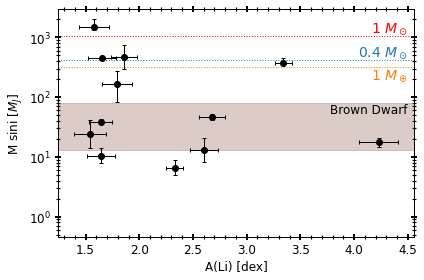

In [17]:
def msini_li(msini,df,unit='Mjup',legend=False):
    PLOT_PARAMS(LS=12, SIZE=12)
    for k, v in msini.items():
        data = np.array(msini[k][unit])
        p16 = np.percentile(data, 16)
        p84 = np.percentile(data, 84)
        p50 = np.percentile(data, 50)
        mass_min = min(data)
        mass_max = max(data)
        yerr=[[p50-p16], [p84-p50]]
        plt.errorbar(df[df.RG_id == k].Li_val, p50, xerr=df[df.RG_id == k].e_Li_val, yerr=yerr,fmt='o',capsize=2,lw=1,mec='k',mfc='k',color='k')
        plt.yscale('log')
        plt.ylabel('M sini [$M_J$]')
        plt.xlabel('A(Li) [dex]')
    
    mearth = (u.Mjup).to(u.Mearth)
    
    msolar = (u.Msun).to(u.Mjup)

    if legend:

        plt.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
        plt.text(4.5, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

        plt.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
        plt.text(4.5, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

        plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
        plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

        plt.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
        plt.text(4.5, 80, s='Brown Dwarf', ha='right',va='top', c='k',fontsize=12)
        #plt.legend()
    
plt.figure()
msini_li(p112_msini, df_p112,legend=True)
msini_li(p113_msini, df_p113)
plt.tight_layout()

In [18]:
def msini_stats(dic, unit):
    for k, v in dic.items():
        print(k)
        data = np.array(dic[k][unit])
        p16 = np.percentile(data, 16)
        p84 = np.percentile(data, 84)
        p50 = np.percentile(data, 50)
        label = 'RG%i : %.2f (%.2f, %.2f)'%(k, p50, p16, p84)
        _ = plt.hist(data,bins='auto',label=label)
        plt.legend()

# msini_stats(p112_msini,'Msol')
# msini_stats(p113_msini,'Msol')

In [19]:
def plot_samples(program, RG, version, obj_dir, ax):
    
    fname = '../mcmc/%s/%s_joker_%s.hdf5'%(program,RG,version)
    joker_samples = tj.JokerSamples.read(fname)
    t, rv, rv_err = np.array(obj_dir[RG]['time']), np.array(obj_dir[RG]['rv']), np.array(obj_dir[RG]['err'])
    mask = (rv >= -100)
    t, rv, rv_err = t[mask], rv[mask], rv_err[mask]

    data = Table()
    data['bjd']     = t
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS(LS=10, SIZE=10)
    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)

    ax.text(0.5, 0.95, '%s - RG %s'%(program[1:], RG), ha='center',va='top', transform=ax.transAxes,fontsize=14,color='k',bbox=dict(facecolor='white', edgecolor='grey',boxstyle='round,pad=0.2'))
    for label in ax.get_xticklabels():
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontsize(10)

    return 0


In [20]:
def plot_msini(dic, RG, unit, program, ax):
    data = np.array(dic[RG][unit])

    p16 = np.percentile(data, 16)
    p84 = np.percentile(data, 84)
    p50 = np.percentile(data, 50)

    _ = ax.hist(data,bins='auto')
    if 'j' in unit:
        unit = '$\mathrm{M_J}$'
    else:
        unit = '$\mathrm{M_\odot}$'
    ax.set_xlabel(r'$M \sin(i)$ ' + '['+unit+']')
    ax.set_ylabel('$N$')
    label = '%.2f (%.2f, %.2f) '%(p50, p16, p84) + unit
    ax.text(0.5, 0.85, label, transform=ax.transAxes,fontsize=12, ha='center',bbox=dict(facecolor='white', edgecolor='grey',boxstyle='round,pad=0.2'))
    ax.axvline(p16, ls='dashed',c='k',lw=1)
    ax.axvline(p50, ls='solid',c='k',lw=1)
    ax.axvline(p84, ls='dashed',c='k',lw=1)
    plt.legend()
    

In [55]:
def get_P_e(objects, program, version, savedict):
    Pdata = {}
    edata = {}
    for RG in objects:
        print(program, RG)
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        colnames = ['P','e','K','v0']
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        p16 = np.percentile(Ps, 16)
        p84 = np.percentile(Ps, 84)
        p50 = np.percentile(Ps, 50)
        
        e16 = np.percentile(es, 16)
        e84 = np.percentile(es, 84)
        e50 = np.percentile(es, 50)
        
        Pdata[RG] = [p16, p50, p84]
        edata[RG] = [e16, e50, e84]
        # Msini_jup   = Msini/u.M_jup.to(u.kg)
        # Msini_solar = Msini/u.Msun.to(u.kg)

    Pdata = pd.DataFrame(Pdata).T
    Pdata.reset_index(inplace=True)
    Pdata.rename(columns={0:'P16', 1:'P50', 2:'P84','index':'RG_id'},inplace=True)
    
    edata = pd.DataFrame(edata).T
    edata.reset_index(inplace=True)
    edata.rename(columns={0:'P16', 1:'P50', 2:'P84','index':'RG_id'},inplace=True)

    return Pdata, edata
p112_P_e = get_P_e(obj_112, 'p112', 1, p112_d)
p113_P_e = get_P_e(obj_113, 'p113', 1, p113_d)

p112 6
p112 7
p112 13
p112 23
p113 7
p113 9
p113 11
p113 16
p113 18
p113 19
p113 21
p113 23


In [28]:
def plot_rv_logg(merged, RG, program, ax):

    mbinary_112 = merged_112[merged_112.RG_id.isin(obj_112)]
    mbinary_113 = merged_113[merged_113.RG_id.isin(obj_113)]
    ax.scatter(merged_112.logg, merged_112.max_rv, c='k')
    ax.scatter(merged_113.logg, merged_113.max_rv, c='k')
    ax.scatter(mbinary_112.logg, mbinary_112.max_rv, s=100, ec='C2',fc='None', label='Binary')
    ax.scatter(mbinary_113.logg, mbinary_113.max_rv, s=100, ec='C2',fc='None', label='Binary')
    ax.scatter(merged[merged.RG_id==RG].logg, merged[merged.RG_id==RG].max_rv, c='r')
    ax.set_xlabel('Logg [dex]')
    ax.set_ylabel('Half Peak-to-Peak [m/s]')
    
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y

    x = np.linspace(0,4,100)    
    
    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    
    ax.plot(x,y1, c='k',ls='solid',lw=1)
    ax.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    ax.plot(x,y3, c='grey',ls='dashed',lw=1)
    ax.set_yscale('log')

In [23]:
p112_units = {6: 'Msol', 
              7: 'Mjup',
             13: 'Msol',
             23: 'Msol',
            }

p113_units = {7: 'Mjup', 
              9: 'Mjup', 
             10: 'Mjup', 
             11: 'Mjup', 
             16: 'Msol', 
             18: 'Msol', 
             19: 'Mjup', 
             21: 'Mjup', 
             23: 'Mjup',
            }

In [24]:

def get_subplots():
    fig = plt.figure(layout="constrained",figsize=(14,8))

    gs = GridSpec(3, 4, figure=fig)   #rows, cols
    ax1 = fig.add_subplot(gs[0, 0:2]) # row, col
    ax2 = fig.add_subplot(gs[1, 0:1]) # row, col
    ax3 = fig.add_subplot(gs[1, 1:2]) # row, col
    ax4 = fig.add_subplot(gs[2, 0:1]) # row, col
    ax5 = fig.add_subplot(gs[2, 1:2]) # row, col
    ax6 = fig.add_subplot(gs[:, 2:4]) # row, col
    return fig,ax1,ax2,ax3,ax4,ax5,ax6


In [25]:

def corner_plot(program, RG, version):
    fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
    with open(fname1, 'rb') as handle:
        mcmc_samples = pickle.load(handle)
    
    colnames = ['P','e','K','v0']
    fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                        labels=[r"$P$", r"$e$", r"$K$",r"$v_0$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12}
                       )
    return fig

In [26]:
def add_corner_plot(fig,ax, RG,program):
    file = 'corner_%s_%s.png'%(RG, program)
    fig.savefig(file,bbox_inches='tight',dpi=150)
    im = mpimg.imread(file)
    def place_image(im, loc=3, ax=None, zoom=1,):
        imagebox = OffsetImage(im, zoom=zoom)
        ab = AnchoredOffsetbox(loc=loc, child=imagebox, frameon=False,pad=0)
        ax.add_artist(ab)
    place_image(im, loc='center left', ax=ax, zoom=0.33)


In [58]:
p112_P_e[0]

,RG_id,P16,P50,P84
0,6,34.731820,35.169194,36.240761
1,7,26.319527,26.729210,27.341903
2,13,85.579329,86.626701,87.660688
3,23,41.146176,41.910317,43.157765


In [59]:
data0

,index,RG_id,P,err_P,e,err_e,K,err_K,r_hat_P,r_hat_e,...,ruwe_dr2,Ba_fe,e_Ba_fe,La_fe,e_La_fe,Zr_fe,e_Zr_fe,Y_fe,e_Y_fe,program
0,0,6.0,36.458,1.090,0.201,0.164,3.876,1.818,1.03,1.00,...,1.03,0.07,0.13,0.03,0.22,NaN,NaN,-0.03,0.19,112
1,1,7.0,26.844,0.616,0.234,0.192,-0.756,0.409,1.01,1.01,...,1.00,0.63,0.11,0.23,0.13,NaN,NaN,0.23,0.16,112
2,2,13.0,86.541,1.074,0.266,0.076,12.218,2.495,1.07,1.08,...,0.93,0.14,0.06,0.44,0.10,NaN,NaN,0.08,0.09,112
3,3,23.0,42.065,1.046,0.177,0.164,-18.423,5.876,1.07,1.03,...,1.04,0.40,0.09,NaN,NaN,0.40,0.14,0.50,0.14,112
4,0,7.0,62.897,1.424,0.740,0.061,0.955,0.178,1.00,1.01,...,0.99,0.81,0.14,0.63,0.13,NaN,NaN,-0.39,0.21,113
5,1,9.0,20.694,0.222,0.181,0.143,0.035,1.623,1.00,1.00,...,0.96,0.38,0.12,0.61,0.13,NaN,NaN,0.19,0.18,113
6,2,11.0,49.811,1.401,0.547,0.109,-1.052,0.460,1.00,1.01,...,0.91,0.61,0.11,NaN,NaN,0.76,0.20,0.90,0.21,113
7,3,16.0,33.953,0.066,0.797,0.048,58.750,20.311,1.00,1.02,...,0.98,-0.21,0.17,NaN,NaN,NaN,NaN,NaN,NaN,113
8,4,18.0,41.465,0.042,0.320,0.069,47.072,11.174,1.00,1.01,...,1.09,0.41,0.13,NaN,NaN,NaN,NaN,0.42,0.25,113
9,5,19.0,52.021,1.162,0.408,0.084,1.979,0.314,1.01,1.01,...,1.13,0.38,0.10,NaN,NaN,NaN,NaN,NaN,NaN,113


In [101]:
def plot_Li_P_e(RG, program, ax, param):
    Pdata112, edata112 = p112_P_e[0], p112_P_e[1]
    Pdata113, edata113 = p113_P_e[0], p113_P_e[1]

    Pdata_112 = pd.merge(stat_dict_112[['Li_val','RG_id','program']], Pdata112, on='RG_id') 
    Pdata_113 = pd.merge(stat_dict_113[['Li_val','RG_id','program']], Pdata113, on='RG_id') 
    
    edata_112 = pd.merge(stat_dict_112[['Li_val','RG_id','program']], edata112, on='RG_id') 
    edata_113 = pd.merge(stat_dict_113[['Li_val','RG_id','program']], edata113, on='RG_id') 
    
    Pdata = pd.concat([Pdata_112, Pdata_113])
    edata = pd.concat([edata_112, edata_113])
    program = int(program[1:])
    
    if param == 'P':
        label = 'Period $P$ [days]'
        d1 = Pdata[(Pdata.RG_id==RG) & (Pdata.program==program)]
        yerr = [d1.P50-d1.P16, d1.P84-d1.P50]

        ax.errorbar(Pdata.Li_val, Pdata.P50, fmt='o')
        ax.errorbar(d1.Li_val, d1.P50,fmt='o',color='r',yerr=yerr)
    else:
        label = 'Eccentricity $e$'
        d1 = edata[(edata.RG_id==RG) & (edata.program==program)]
        ax.errorbar(edata.Li_val, edata.P50, fmt='o')
        ax.errorbar(d1.Li_val, d1.P50,fmt='o',color='r')
        
    ax.set_xlabel('A(Li) [dex]')
    ax.set_ylabel(label)
    return Pdata#print(Pdata)

,Li_val,RG_id,program,P16,P50,P84
0,1.79,6.0,112,34.731820,35.169194,36.240761
1,2.60,7.0,112,26.319527,26.729210,27.341903
2,3.34,13.0,112,85.579329,86.626701,87.660688
3,1.86,23.0,112,41.146176,41.910317,43.157765
0,4.23,7.0,113,61.518701,62.630900,64.275983
1,1.54,9.0,113,20.491954,20.658412,20.892938
2,1.64,11.0,113,30.495720,31.200513,32.160385
3,1.65,16.0,113,50.583190,50.970535,51.712791
4,1.58,18.0,113,41.422569,41.465976,41.507236
5,2.68,19.0,113,50.856545,51.948343,53.188426


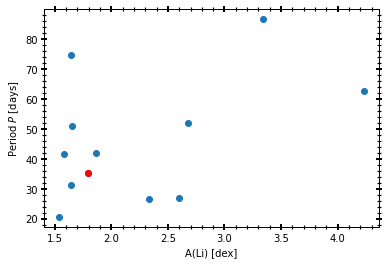

In [102]:
ax=plt.subplot(111)
plot_Li_P_e(6, 'p112', ax, 'P')

In [67]:
# def plot_Li_P_e(RG, program, ax, param):
# #     Pdata112, edata112 = p112_P_e[0], p112_P_e[1]
# #     Pdata113, edata113 = p113_P_e[0], p113_P_e[1]
# #     Pdata = pd.concat([Pdata112, Pdata113])
# #     edata = pd.concat([edata112, edata113])
    
#     program = int(program[1:])
    
#     if param == 'P':
#         label = 'Period $P$ [days]'
        
#     else:
#         label = 'Eccentricity $e$'
#     d1 = data0[(data0.RG_id==RG) & (data0.program==program)]
#     ax.scatter(data0.Li_val, data0[param], c='k')
#     ax.scatter(d1.Li_val, d1[param], c='r',s=100)
    
# #         ax.scatter()
#     ax.set_xlabel('A(Li) [dex]')
#     ax.set_ylabel(label)

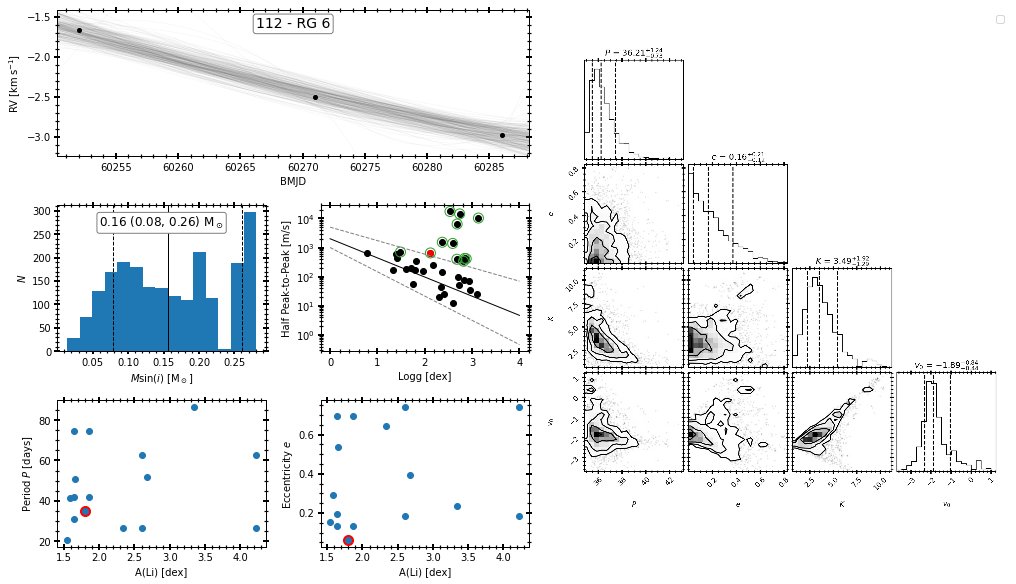

In [72]:

program = 'p112'
for RG in obj_112[0:1]:
    version = p112_ver[RG]
    fig,ax1,ax2,ax3,ax4,ax5,ax6 = get_subplots()
    plot_samples(program, RG, version, obj_dir_p112, ax1)
    unit = p112_units[RG]
    plot_msini(p112_msini, RG, unit, program, ax2)
    plot_rv_logg(merged_112, RG, program, ax3)
    plot_Li_P_e(RG, program, ax4, 'P')
    plot_Li_P_e(RG, program, ax5, 'e')
    ax6.set_axis_off()
    corner_fig = corner_plot(program, RG, version)
    add_corner_plot(corner_fig, ax6, RG, program )
    name = '../plots/diagnostic_plots/%s_%s.png'%(RG, program)
    fig.savefig(name,bbox_inches='tight',dpi=150)
    plt.close(corner_fig)
    #plt.close(fig)
    
    
# program = 'p113'
# for RG in obj_113:
#     version = p113_ver[RG]
#     fig, ax1,ax2,ax3,ax4,ax5,ax6 = get_subplots()
#     plot_samples(program, RG, version, obj_dir_p113, ax1)
#     unit = p113_units[RG]
#     plot_msini(p113_msini, RG, unit, program, ax2)
#     plot_rv_logg(merged_113, RG, program, ax3)
#     plot_Li_P_e(RG, program, ax4, 'P')
#     plot_Li_P_e(RG, program, ax5, 'e')
#     ax6.set_axis_off()
#     corner_fig = corner_plot(program, RG, version)
#     add_corner_plot(corner_fig, ax6, RG, program )
#     name = '../plots/diagnostic_plots/%s_%s.png'%(RG, program)
#     fig.savefig(name,bbox_inches='tight',dpi=150)
#     plt.close(corner_fig)
#     plt.close(fig)


In [ ]:
ss

# M/W analysis

In [ ]:
df_final = Table.read('../../lithium/final_paper_sample_09_18.csv').to_pandas()


In [ ]:
PLOT_PARAMS(LS=12,SIZE=12)
# plt.rcParams['figure.facecolor']    = 'white'
# 

In [ ]:
def get_mw(rid, ax, label):
    pid = df_final[df_final.galah_rich_id==rid].galah_poor_id.to_numpy()[0]
    rich_spectrum=get_spectra(rid,'rich',False)

    poor_spectrum=get_spectra(pid,'poor',)
    rwave_og = rich_spectrum['wave_norm_3']
    rflux_og = rich_spectrum['sob_norm_3']
    rerr     = rich_spectrum['uob_norm_3']

    pwave_og = poor_spectrum['wave_norm_3']
    pflux_og = poor_spectrum['sob_norm_3']
    perr     = poor_spectrum['uob_norm_3']

    wavelength_grid  = np.linspace(min(rwave_og),max(rwave_og),len(rwave_og))


    _,rflux = interpolate_to_grid(xdata=rwave_og, ydata=rflux_og, xgrid=wavelength_grid)
    _,pflux = interpolate_to_grid(xdata=pwave_og, ydata=pflux_og, xgrid=wavelength_grid)
    _,rerr  = interpolate_to_grid(xdata=rwave_og, ydata=rerr,  xgrid=wavelength_grid)
    _,perr  = interpolate_to_grid(xdata=pwave_og, ydata=perr,  xgrid=wavelength_grid)
    diff    = rflux-pflux
    x,dx    = 6563, 5
    x,dA  = 6563,5
    llim,ulim=x-dA,x+dA
    mask  = (wavelength_grid <= ulim) & (wavelength_grid>=llim)
    wavelength_grid = wavelength_grid[mask]
    rflux = rflux[mask]
    pflux = pflux[mask] 
    ax.plot(wavelength_grid,rflux-pflux,c='grey', lw=4, label=label)
    ax.plot(wavelength_grid,rflux-pflux,c='gold')
    ax.axvline(x,c='grey',ls='dotted',zorder=0)
    ax.axhline(0,c='grey',ls='dotted',zorder=0)
    ax.set_xlim(llim+1, ulim-1)
    #ax.legend()
    
fig = plt.figure(figsize=(12,6))
for i, row in data.iterrows():
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    vbroad = row['vbroad']
    rid = row['galah_id']
    #print(rid)
    if i > 5: continue
    ax = plt.subplot(2,3,i+1)
    try:
        
        label = ' K = %.2f km/s \n P = %.1f days \n e = %.1f \n M$s$= %.1f $M_\odot$ \n vbr = %.1f km/s' % (K, P, e, Mstar,vbroad)
        get_mw(rid, ax, label)

        #ax.legend(fontsize=12,)
        #if i<3:
        #    ax.text(0.5, 1.01, label, fontsize=11, ha='center',va='bottom', transform = ax.transAxes)
        #else:
        
        if i == 0:
            ax.text(0.97, 0.05, label, fontsize=10, ha='right',va='bottom', transform = ax.transAxes)
        else:
            ax.text(0.97, 0.95, label, fontsize=10, ha='right',va='top', transform = ax.transAxes)
            
        if i in [0,1,2]: ax.set_ylabel('Rich - Twin')
        if i > 2: 
            ax.set_xlabel('Wavelength ['+r'$\mathrm{\AA}$'+']')
        if i in [0,1,2]:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    except Exception as e:
        print(e)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/m_vs_w_1_%s.png'%DATE,bbox_inches='tight',dpi=150)

fig = plt.figure(figsize=(12,6))
for i, row in data.iterrows():
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    vbroad = row['vbroad']
    rid = row['galah_id']
    if i < 6: continue
    n = i-6+1
    ax = plt.subplot(2,3,n)
    try:
        label = ' K = %.2f km/s \n P = %.1f days \n e = %.1f \n M$s$= %.1f $M_\odot$ \n vbr = %.1f km/s' % (K, P, e, Mstar,vbroad)
        get_mw(rid, ax, label)
        if n==5:
            ax.text(0.03, 0.05, label, fontsize=10, ha='left',va='bottom', transform = ax.transAxes)
        else:
            ax.text(0.97, 0.95, label, fontsize=10, ha='right',va='top', transform = ax.transAxes)
            
        if i in [0,1,2]: ax.set_ylabel('Rich - Twin')
        if i > 2: 
            ax.set_xlabel('Wavelength ['+r'$\mathrm{\AA}$'+']')
        if i in [0,1,2]:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    except Exception as e:
        print(e)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/m_vs_w_2_%s.png'%DATE,bbox_inches='tight',dpi=150)
